# Classification of spoken digits

Here, we explore the spoken digits dataset. This is a great dataset, because there are so many different approaches you can take. Rather than jumping into a complex model (such as a neural network), we will try and make our approach as simple as possible.

We start by just loading a couple of examples. Since this is a pretty core operation, it helps to start writing functions right away.

In [2]:
from scipy.io.wavfile import read

def load_audio_file(file_path):
    sr, data = read(file_path)
    return data, sr


In [7]:
example1, sampling_rate1 = load_audio_file('../../audio-classifier/recordings/7_theo_36.wav')
example2, sampling_rate2 = load_audio_file('../../audio-classifier/recordings/0_jackson_1.wav')
print(example1.shape, sampling_rate1)
print(example2.shape, sampling_rate2)

(17567,) 8000
(4261,) 8000


OK, so the sampling rates are the same, but the audio lengths are very different...this is annoying, as most models require a fixed number of features. Let's just check and see how severe the length distribution is:

In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np

def get_audio_time_series_lengths(folder_path):
    audio_time_series_lengths = []
    for file in os.listdir(folder_path):
        if file.endswith('.wav'):
            audio, sampling_rate = load_audio_file(os.path.join(folder_path, file))
            audio_time_series_lengths.append(len(audio))
    return audio_time_series_lengths

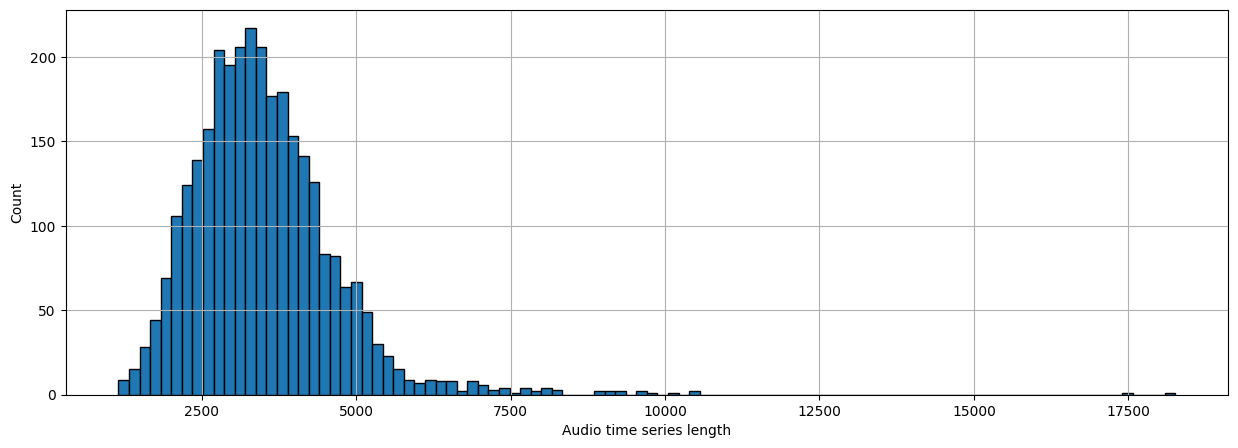

In [10]:
audio_time_series_lengths = get_audio_time_series_lengths('../../audio-classifier/recordings')

h, bins = np.histogram(audio_time_series_lengths, bins=100)

fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(bins[:-1], h, width=np.diff(bins), ec="k", align="edge")
ax.set_xlabel('Audio time series length')
ax.set_ylabel('Count')
ax.grid()
plt.show()

OK, so there are some serious outliers, let's have a look at one in the time and frequency domain.

In [11]:
# transform the audio time series into the frequency domain using the discrete Fourier transform
from scipy.fft import fft, fftfreq

def transform_audio_to_frequency_domain(audio, sampling_rate, n=4000):
    T = 1 / sampling_rate
    yf = fft(audio)
    xf = fftfreq(n, T)[:n//2]
    return xf, yf


xf1, yf1 = transform_audio_to_frequency_domain(example1, sampling_rate1)

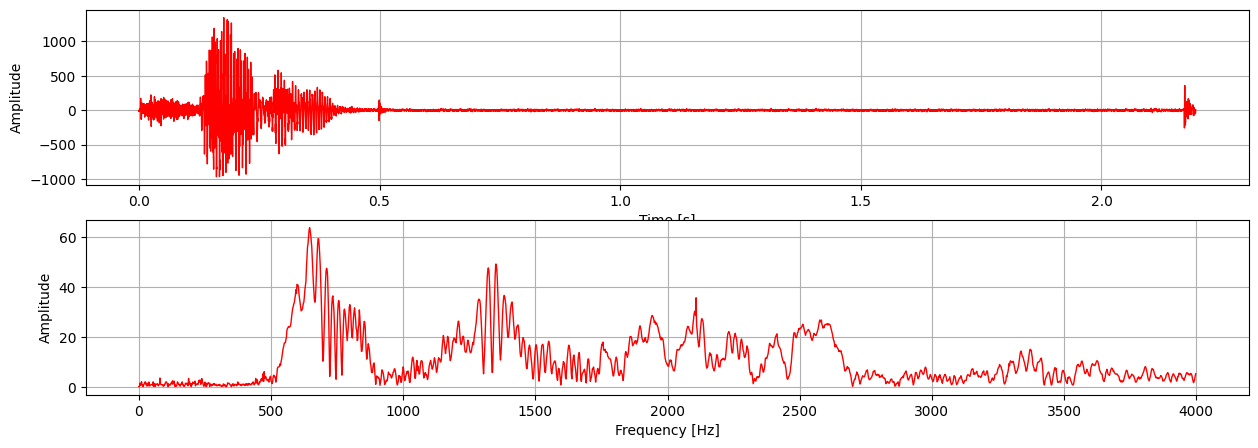

In [12]:


time = np.arange(0, len(example1)) / sampling_rate1
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5))
ax1.plot(time, example1, lw=1, color='r', label='Example 1')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Amplitude')

ax2.plot(xf1, 2.0 / 4000 * np.abs(yf1[:4000//2]), lw=1, color='r', label='Example 1')
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Amplitude')

ax1.grid()
ax2.grid()
plt.show()

One approach here would be to write a function that finds and throws away this long tail of silence. Since we're just collecting summary stats from spectrograms, this probably won't be an issue, but if performance is bad, this might be something worth coming back to.

There is useful information in both the time and frequency domain so let's use both by turning our samples into mel spectrograms. From here, we can collect summary statistics from the spectrograms: mean, standard deviation. We do this for each mel bin (each row in the spectrogram matrix.)

In [13]:
import torch
import torchaudio.transforms as T

def generate_mel_spectrogram(audio, sample_rate):
    transform = T.MelSpectrogram(sample_rate, normalized=True)
    S = transform(torch.from_numpy(audio).type(torch.float))
    S = 10 * torch.log10(S)
    return S.numpy()

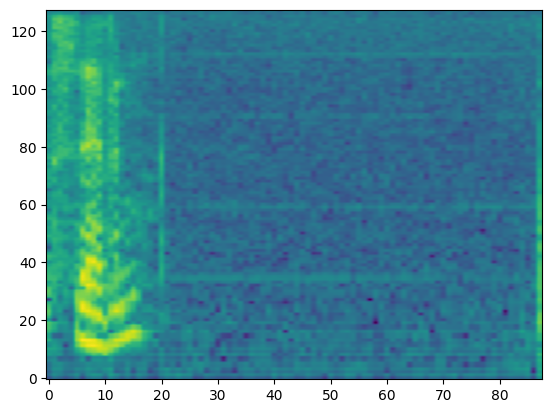

In [18]:
S = generate_mel_spectrogram(example1, 8000)

plt.imshow(S, interpolation=None, aspect='auto', origin='lower')
plt.show()

We now essentially want to generate a generic dataset, that we can use for some simple ML models. There are a few ways we can go about doing this:
- make a custom scikit-learn transformation that converts the dataset into spectrograms;
- make a custom class that reads from the folder, and converts the data.
- write a bunch of functions that read the audio and convert to spectrogram.

There's no right or wrong answer here, you're looking for the approach that is a balance between readability, computational complexity, time efficiency, and can be extended to other audio files.

What assumptions do we make? The sample rate is 8kHz - do we impose this on others so that they should also be using 8kHz sample rates?

Let's get started. We already have a function that loads an audio file, and a function that generates a spectrogram from an audio. Now we write a function that does this for every audio file in a folder and saves the results to a data structure.

In [19]:
S.shape

(128, 88)

In [20]:
def summary_statistics(spectrogram : np.ndarray):
    mean = spectrogram.mean(axis=1)
    std = spectrogram.std(axis=1)
    stats = np.concatenate([mean, std])

    return stats


def get_data(folder_path):
    labels = []
    data = []
    for file in os.listdir(folder_path):
        if file.endswith('.wav'):
            # Get spectrogram and summary statistics
            audio, sampling_rate = load_audio_file(os.path.join(folder_path, file))
            log_S = generate_mel_spectrogram(audio, sampling_rate)
            stats = summary_statistics(log_S)
            data.append(stats)

            # Get labels
            label = int(file[:1])
            labels.append(label)

    return np.array(data), np.array(labels)

In [22]:
data, labels = get_data('../../audio-classifier/recordings')

So now we have some data and some labels. Let's try the same pipeline as we used in Lab 2.

In [23]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [24]:
# Test train split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=1337)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1337)
print(y_train.shape, y_val.shape, y_test.shape)

(1687,) (563,) (750,)


In [25]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline

estimator = Pipeline([
    ("scaler", MinMaxScaler()),
    ("pca", PCA(n_components=2)),
    ("classifier", KNeighborsClassifier())
])

estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_val)
print(f"Accuracy: {accuracy_score(y_val, y_pred):.2f}")

Accuracy: 0.28


So using default settings is terrible. This dataset is perfectly balanced, so this model is actually a pretty good starting benchmark. Let's do some hyperparameter optimization.

In [26]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=1337)

param_grid = {
    "pca__n_components": np.arange(1, 48),
    "classifier__n_neighbors": np.arange(1, 48)
}

estimator = Pipeline([
    ("scaler", MinMaxScaler()),
    ("pca", PCA()),
    ("classifier", KNeighborsClassifier())
])

# clf = RandomizedSearchCV(estimator, param_grid, n_iter=10000, cv=5, verbose=1, n_jobs=-1)
clf = GridSearchCV(estimator, param_grid, cv=5, verbose=1, n_jobs=-1)
search = clf.fit(X_train, y_train)

Fitting 5 folds for each of 2209 candidates, totalling 11045 fits


In [27]:
print(f"Best parameters: {search.best_params_}")

Best parameters: {'classifier__n_neighbors': 1, 'pca__n_components': 41}


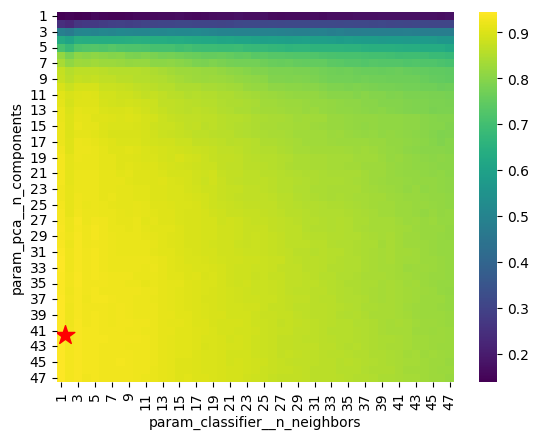

In [28]:
# plot heatmap of the validation accuracy as a function of n_components and n_neighbors
import pandas as pd

df = pd.DataFrame(search.cv_results_)

import seaborn as sns

sns.heatmap(df.pivot_table(index="param_pca__n_components", columns="param_classifier__n_neighbors", values="mean_test_score"),fmt=".3f", cmap="viridis")
plt.scatter(search.best_params_["classifier__n_neighbors"], search.best_params_["pca__n_components"], marker="*", s=200, c="r")

In [29]:
# Best model
y_pred = search.best_estimator_.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Accuracy: 0.96


OK, great. Our initial model works pretty well. But think about what else we can optimize here. There are other hyperparamters that might play a role, namely the `n_mels`, `hop_length`, and `n_fft`. It might be useful to write a custom transformation class that will allow us to alter these hyperparameters.

We have a number of functions that we have written that we can combine into a cutom data transformation class. Consider what we want as the starting point - we don't need to read any files, so that can remain separated, we just need to create spectrograms and get the summary statistics. In our pipeline, `X` is now a list of audio files.

In [45]:
from numpy import ndarray
from sklearn.base import BaseEstimator, TransformerMixin

class SummaryStats(BaseEstimator, TransformerMixin):
    def __init__(self, sr : int = 8000,
                 n_fft : int = 256,
                 hop_length : int = 128,
                 n_mels : int = 40):
        """Generates spectrograms and summary statistics of audio data.

        Args:
            sr (int, optional): sample rate. Defaults to 8000.
            n_fft (int, optional): number of fft components. Defaults to 1024.
            hop_length (int, optional): hop length. Defaults to 128.
            n_mels (int, optional): number of mels. Defaults to 128.
        """
        super().__init__()
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels


    def fit(self, X, y=None):
        return self


    def transform(self, X : list) -> ndarray:
        """Transform input data

        Args:
            X (list): List of audio streams.

        Returns:
            ndarray: Summary statistics of audio streams.
        """
        data = []
        for x in X:
            # Get spectrogram and summary statistics
            log_S = self.generate_mel_spectrogram(x)
            stats = self.summary_statistics(log_S)
            data.append(stats)
        return np.array(data)


    def generate_mel_spectrogram(self, audio : ndarray) -> ndarray:
        """Gets a mel spectrogram from audio data

        Args:
            audio (ndarray): a 1D audio stream.

        Returns:
            ndarray: Spectrogram
        """
        transform = T.MelSpectrogram(sample_rate=self.sr,
                                     n_fft=self.n_fft,
                                     hop_length=self.hop_length,
                                     n_mels=self.n_mels,
                                     normalized=True)
        S = transform(torch.from_numpy(audio).type(torch.float))
        S = 10 * torch.log10(S)
        return S.numpy()
    

    def summary_statistics(self, spectrogram : ndarray) -> ndarray:
        """Get mean and standard deviation of each frequency row.

        Args:
            spectrogram (np.ndarray): A spectrogram

        Returns:
            ndarray: An array of size 2*n_mels.
        """
        mean = spectrogram.mean(axis=1)
        std = spectrogram.std(axis=1)
        stats = np.concatenate([mean, std])

        return stats


But we now need to modify how we read our data from the folder and collect labels. Take a minute and see if you can do this by yourself in the cell below: 

In [46]:
def get_data(folder_path):
    labels = []
    audio_data = []
    for file in os.listdir(folder_path):
        if file.endswith('.wav'):
            # Get spectrogram and summary statistics
            audio, _ = load_audio_file(os.path.join(folder_path, file))
            audio_data.append(audio)

            # Get labels
            label = int(file[:1])
            labels.append(label)

    return audio_data, np.array(labels)

data, labels = get_data('../../audio-classifier/recordings')

In [54]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from seeds import set_all_seeds

set_all_seeds(0)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25)

param_grid = {
        "summary_stats__n_mels" : np.array([32, 64]),
        "pca__n_components" : np.arange(16, 72, 2),
        "classifier__n_neighbors" : np.arange(1,27,2)
    }

estimator = Pipeline([
    ("summary_stats", SummaryStats()),
    ("scaler", MinMaxScaler()),
    ("pca", PCA()),
    ("classifier", KNeighborsClassifier())
])

clf = RandomizedSearchCV(estimator, param_grid, n_iter=10000, cv=5, verbose=1, n_jobs=-1)
clf = GridSearchCV(estimator, param_grid, cv=5, verbose=1, n_jobs=-1)
search = clf.fit(X_train, y_train)
y_pred = search.best_estimator_.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Fitting 5 folds for each of 728 candidates, totalling 3640 fits


/Users/rkd/Pipelines/AutumnSchool/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
195 fits failed out of a total of 3640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
65 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rkd/Pipelines/AutumnSchool/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rkd/Pipelines/AutumnSchool/venv/lib/python3.9/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/rkd/Pipelines/AutumnSchool/venv/lib/python3.9/site-packages/sklearn/pipeline.py

Accuracy: 0.95


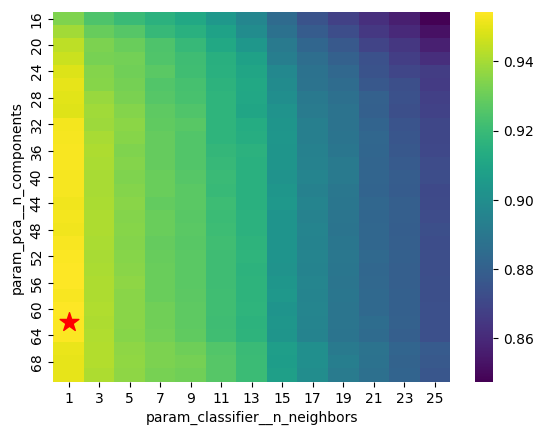

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(search.cv_results_)

import seaborn as sns

sns.heatmap(df.pivot_table(index="param_pca__n_components", columns="param_classifier__n_neighbors", values="mean_test_score"),fmt=".3f", cmap="viridis")
plt.scatter(np.where(param_grid['classifier__n_neighbors']==search.best_params_["classifier__n_neighbors"])[0]+0.5,
            np.where(param_grid['pca__n_components']==search.best_params_["pca__n_components"])[0]+0.5, 
            marker="*", s=200, c="r")
plt.show()

Now we have a class that will do this tranformation for us. And what about if we just want to assess a single audio file, and make a prediction? Can we do this?

So we've tried our model, it works well, and now we have this extra layer of complexity, and things are starting to get a bit out of control. We have so many moving parts, it's hard to keep track of everything, and how do I really know that things are working correctly...

Let's suppose that our entire project is simply using KNN to solve the spoken digit classification problem. We have some results, and now we want to package everything up and make sure that it all works in the way that we intended...